In [14]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L

In [15]:
def psi(g,e):
    return np.array([g, e])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    result = psi(0.0+0.0j,0.0+0.0j)
    for n in range(Ncut):
        result += prob(n,nbar)*pulse(t, Omega0*Omega(n,0,eta), delPrime, 0.0, 0.0)@psi0
    return result

def therm3DPulse(psi0, t, Omega0, delPrime, nbars, Omegas, Ncut):
    nbarx = nbars[0]
    nbary = nbars[1]
    nbarz = nbars[2]
    #Ncut = 100
    result = psi(0.0+0.0j,0.0+0.0j)
    for nx in range(Ncut):
        Probx = prob(nx,nbarx)
        for ny in range(Ncut):
            Probxy = Probx*prob(ny,nbary)
            for nz in range(Ncut):
                result += Probxy*prob(nz,nbarz)*pulse(t, Omega0*Omegas[nx,ny,nz], delPrime, 0.0, 0.0)@psi0
    return result

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

def Omega(n,m,eta):
    return np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2)              #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

In [16]:
def HRerrSig(psi0, t1, T, t2, delta, delPrime, Omega01, Omega02):
    pulse1 = pulse(t1, Omega01, delPrime, 0.0, 0.0)
    pulse2 = pulse(t2, Omega02, delPrime, 0.0, 0.0)
    freeEvo = pulse(T, 0.0, delta, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    
    return rhoee(pulse2@freeEvo@pi2PhaseInjP@pulse1@psi0) - rhoee(pulse2@freeEvo@pi2PhaseInjM@pulse1@psi0)

$\delta_d = $ dark time detuning and $\Delta$ = light shift estimate error (LSEE)

In [17]:
def HRJumperrSig(deld, psi0, t1, T, t2, Delta, Omega01, Omega02, Omega03):
    delPrime = deld - Delta
    pulse1 = pulse(t1, Omega01, delPrime, 0.0, 0.0)
    pulse2 = pulse(2.0*t2/3.0, -Omega02, delPrime, 0.0, 0.0)
    pulse3 = pulse(t2/3.0, Omega03, delPrime, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    return rhoee(pulse3@pulse2@pi2PhaseInjP@freeEvo@pulse1@psi0) - rhoee(pulse3@pulse2@pi2PhaseInjM@freeEvo@pulse1@psi0)

def HRJumpThermErrSig3D(deld, psi0, t1, T, t2, Delta, Omega0s, nbars, Omegas, Ncut):
    Omega01 = Omegas[0]
    Omega02 = Omegas[1]
    Omega03 = Omegas[2]
    nbarx = nbars[0]
    nbary = nbars[1]
    nbarz = nbars[2]
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    intState = freeEvo@therm3DPulse(psi0, t1, Omega01, delPrime, nbars, Omegas, Ncut)
    resultP = therm3DPulse(therm3DPulse(pi2PhaseInjP@intState, 2.0*t2/3.0, -Omega02, delPrime, nbars, Omegas, Ncut), t2/3.0, Omega03, delPrime, nbars, Omegas, Ncut)
    resultM = therm3DPulse(therm3DPulse(pi2PhaseInjM@intState, 2.0*t2/3.0, -Omega02, delPrime, nbars, Omegas, Ncut), t2/3.0, Omega03, delPrime, nbars, Omegas, Ncut)
    return rhoee(resultP) - rhoee(resultM)

def HRJumpThermErrSig(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbardot, Ncut):
    nbar = nbar0 + nbardot*T
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    #def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    intState = thermPulse(psi0, t1, Omega0, delPrime, eta, nbar0, Ncut)
    resultP = thermPulse(thermPulse(freeEvo@pi2PhaseInjP@intState, 2.0*t2/3.0, -Omega0, delPrime, eta, nbar, Ncut), t2/3.0, Omega0, delPrime, eta, nbar, Ncut)
    resultM = thermPulse(thermPulse(freeEvo@pi2PhaseInjM@intState, 2.0*t2/3.0, -Omega0, delPrime, eta, nbar, Ncut), t2/3.0, Omega0, delPrime, eta, nbar, Ncut)
    return rhoee(resultP) - rhoee(resultM)

def HRJumpThermErrSigTest(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbardot, Ncut):
    nbar = nbar0 + nbardot*T
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    #def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    intState = thermPulse(psi0, t1, Omega0, delPrime, eta, nbar0, Ncut)
    resultP = thermPulse(thermPulse(pi2PhaseInjP@freeEvo@intState, 2.0*t2/3.0, -Omega0, delPrime, eta, nbar, Ncut), t2/3.0, Omega0, delPrime, eta, nbar, Ncut)
    resultM = thermPulse(thermPulse(pi2PhaseInjM@freeEvo@intState, 2.0*t2/3.0, -Omega0, delPrime, eta, nbar, Ncut), t2/3.0, Omega0, delPrime, eta, nbar, Ncut)
    return rhoee(resultP) - rhoee(resultM)

def RamseyErrSig(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbardot, Ncut):
    nbar = nbar0 + nbardot*T
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    intState = thermPulse(psi0, t1, Omega0, delPrime, eta, nbar0, Ncut)
    resultP = thermPulse(freeEvo@pi2PhaseInjP@intState, t2, Omega0, delPrime, eta, nbar, Ncut)
    resultM = thermPulse(freeEvo@pi2PhaseInjM@intState, t2, Omega0, delPrime, eta, nbar, Ncut)
    return rhoee(resultP) - rhoee(resultM)

def RamseyErrSigTest(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbardot, Ncut):
    nbar = nbar0 + nbardot*T
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    intState = thermPulse(psi0, t1, Omega0, delPrime, eta, nbar0, Ncut)
    resultP = thermPulse(pi2PhaseInjP@freeEvo@intState, t2, Omega0, delPrime, eta, nbar, Ncut)
    resultM = thermPulse(pi2PhaseInjM@freeEvo@intState, t2, Omega0, delPrime, eta, nbar, Ncut)
    return rhoee(resultP) - rhoee(resultM)

In [21]:
Ncut = 201
psi0 = psi(0.0, 1.0)
Delta = 2.0*(2.0*np.pi)  #hz
Omega0 = 10.0*(2.0*np.pi) #hz
nbardot = 5.0 #n/sec
nbar0 = 20.0
t1 = np.pi/(2.0*Omega0)
T = 50.0/Omega0
t2 = 3.0*np.pi/(2.0*Omega0)
eta = 0.05

tol = 1.0e-10
x0 = -0.01
x1 = 0.05

pts = 25
delds = np.linspace(-20.0, 20.0, pts)
errSigPts1 = np.zeros(pts,)
errSigPts2 = np.zeros(pts,)
RhoeeM = np.zeros(pts,)
RhoeeP = np.zeros(pts,)
dif = np.zeros(pts,)
for ii in range(pts):
    print(ii)
    #HRJumpThermErrSig(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbardot, Ncut):
    errSigPts1[ii] = HRJumpThermErrSig(delds[ii], psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbardot, Ncut)
    errSigPts2[ii] = HRJumpThermErrSigTest(delds[ii], psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbardot, Ncut)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


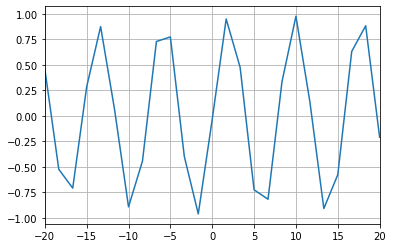

In [23]:
plt.plot(delds,errSigPts1, label = "err")
plt.plot(delds,errSigPts2, label = "err")
#plt.plot([sp.optimize.root_scalar(HRJumpThermErrSig, args=(psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbardot, Ncut), bracket=[x0 ,x1]).root],[0.0],marker='x',markersize=10)
plt.xlim([-20.0,20.0])
#plt.ylim([-0.0001, 0.0001])
plt.grid()
plt.show()

In [48]:
sp.optimize.root_scalar(HRJumpThermErrSig, args=(psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbardot, Ncut), bracket=[-0.01,0.05], xtol = 1e-10)

      converged: True
           flag: 'converged'
 function_calls: 5
     iterations: 4
           root: 0.0010609390442808224

In [27]:
pts = 6
Ncut = 201
psi0 = psi(0.0, 1.0)
Deltas = np.linspace(0.0,  1.0*(2.0*np.pi), 2) #hz
Omega0 = 50.0*(2.0*np.pi) #hz
nbardot = 5.0 #n/sec
t1 = np.pi/(2.0*Omega0)
T = 20.0/Omega0
t2 = 3.0*np.pi/(2.0*Omega0)
eta = 0.05
nbars = np.linspace(0,50, pts)
shifts1 = np.zeros((pts,np.size(Deltas)))
shifts2 = np.zeros((pts,np.size(Deltas)))

tol = 1.0e-11
x0 = -0.01
x1 = 0.05
guessTol = 0.05

#def HRJumpThermErrSig(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar, Ncut):

for jj in range(np.size(Deltas)):
    x0 = -0.01
    x1 = 0.05
    for ii in range(pts):
        print(ii)
        shifts1[ii][jj] = sp.optimize.root_scalar(HRJumpThermErrSig, args=(psi0, t1, T, t2, Deltas[jj], Omega0, eta, nbars[ii], nbardot, Ncut), bracket=[x0,x1], xtol = tol).root
        shifts2[ii][jj] = sp.optimize.root_scalar(HRJumpThermErrSigTest, args=(psi0, t1, T, t2, Deltas[jj], Omega0, eta, nbars[ii], nbardot, Ncut), bracket=[x0,x1], xtol = tol).root
        x0 = shifts1[ii][jj] - guessTol
        x1 = shifts1[ii][jj] + guessTol

0
1
2
3
4
5
0
1
2
3
4
5


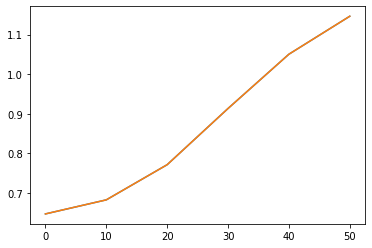

In [32]:
#plt.plot(nbars,shifts1[:,0]*1.0e3)
plt.plot(nbars,shifts1[:,1]*1.0e3)
#plt.plot(nbars,shifts2[:,0]*1.0e3)
plt.plot(nbars,shifts2[:,1]*1.0e3)
#plt.plot(nbars,shifts[:,2]*1.0e3)
#plt.plot(nbars,shifts[:,3]*1.0e3)
#plt.plot(nbars,shifts[:,4]*1.0e3)

In [73]:
Deltas/(2.*np.pi)

array([0.  , 1.25, 2.5 , 3.75, 5.  ])

In [51]:
pts = 5
Ncut = 201
psi0 = psi(0.0, 1.0)
Delta = 1.0*2.0*np.pi #hz
Omega0 = 50.0*(2.0*np.pi) #hz
nbardot = 5.0 #n/sec
t1 = np.pi/(2.0*Omega0)
Ts = np.array([20.0/Omega0, 40.0/Omega0, 60.0/Omega0])
t2 = 3.0*np.pi/(2.0*Omega0)
eta = 0.05
nbars = np.linspace(0,50, pts)
shifts1 = np.zeros((pts,np.size(Ts)))
shifts2 = np.zeros((pts,np.size(Ts)))

tol = 1.0e-11
x0 = -0.01
x1 = 0.05
guessTol = 0.05

for jj in range(np.size(Ts)):
    for ii in range(pts):
        print(ii)
        shifts2[ii][jj] = sp.optimize.root_scalar(HRJumpThermErrSigTest, args=(psi0, t1, Ts[jj], t2, Delta, Omega0, eta, nbars[ii], nbardot, Ncut), bracket=[x0,x1], xtol = tol).root
        shifts1[ii][jj] = sp.optimize.root_scalar(HRJumpThermErrSig, args=(psi0, t1, Ts[jj], t2, Delta, Omega0, eta, nbars[ii], nbardot, Ncut), bracket=[x0,x1], xtol = tol).root
        x0 = shifts1[ii][jj] - guessTol
        x1 = shifts1[ii][jj] + guessTol

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


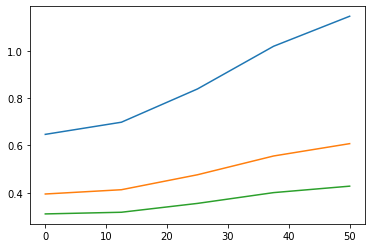

In [52]:
plt.plot(nbars,shifts1[:,0]*1.0e3)
plt.plot(nbars,shifts1[:,1]*1.0e3)
plt.plot(nbars,shifts1[:,2]*1.0e3)
#plt.plot(nbars,shifts2[:,0]*1.0e3)
#plt.plot(nbars,shifts2[:,1]*1.0e3)
#plt.plot(nbars,shifts2[:,2]*1.0e3)

In [40]:
pts = 10
Ncut = 201
psi0 = psi(0.0, 1.0)
Delta = 1.0*2.0*np.pi #hz
Omega0 = 50.0*(2.0*np.pi) #hz
nbardot = 5.0 #n/sec
t1 = np.pi/(2.0*Omega0)
T = 20.0/Omega0
eta = 0.05
nbars = np.linspace(0,50, pts)
shifts3a = np.zeros(pts)
shifts5a = np.zeros(pts)
shifts7a = np.zeros(pts)
shifts3b = np.zeros(pts)
shifts5b = np.zeros(pts)
shifts7b = np.zeros(pts)

tol = 1.0e-11
x0 = -0.1
x1 = 0.5
guessTol = 0.05

#def HRJumpThermErrSig(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar, Ncut):

for ii in range(pts):
    print(ii)
    shifts3a[ii] = sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, 3.0*np.pi/(2.0*Omega0), Delta, Omega0, eta, nbars[ii], nbardot, Ncut), bracket=[x0,x1], xtol = tol).root
    shifts3b[ii] = sp.optimize.root_scalar(RamseyErrSigTest, args=(psi0, t1, T, 3.0*np.pi/(2.0*Omega0), Delta, Omega0, eta, nbars[ii], nbardot, Ncut), bracket=[x0,x1], xtol = tol).root
    x0 = shifts3a[ii] - guessTol
    x1 = shifts3a[ii] + guessTol

0
1
2
3
4
5
6
7
8
9


In [53]:
x0 = -0.1
x1 = 1.0
for ii in range(pts):
    print(ii)
    shifts5a[ii] = sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, 5.0*np.pi/(2.0*Omega0), Delta, Omega0, eta, nbars[ii], nbardot, Ncut), bracket=[x0,x1], xtol = tol).root
    #shifts5b[ii] = sp.optimize.root_scalar(RamseyErrSigTest, args=(psi0, t1, T, 5.0*np.pi/(2.0*Omega0), Delta, Omega0, eta, nbars[ii], nbardot, Ncut), bracket=[x0,x1], xtol = tol).root
    x0 = shifts5a[ii] - guessTol
    x1 = shifts5a[ii] + guessTol

0
1


ValueError: f(a) and f(b) must have different signs

In [45]:
x0 = -0.5
x1 = 0.5
guessTol = 1.0
pts = 10
for ii in range(pts):
    print(ii)
    shifts7a[ii] = sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, 7.0*np.pi/(2.0*Omega0), Delta, Omega0, eta, nbars[ii], nbardot, Ncut), bracket=[x0,x1], xtol = tol).root
    shifts7b[ii] = sp.optimize.root_scalar(RamseyErrSigTest, args=(psi0, t1, T, 7.0*np.pi/(2.0*Omega0), Delta, Omega0, eta, nbars[ii], nbardot, Ncut), bracket=[x0,x1], xtol = tol).root
    x0 = shifts7a[ii] - guessTol
    x1 = shifts7a[ii] + guessTol
    print(x0, x1)

0
-1.007221350731692 0.9927786492683078
1
-1.0686664410751276 0.9313335589248724
2
-1.142741652889209 0.8572583471107912
3
-1.2332554922872094 0.7667445077127905
4
-1.3457887161865472 0.6542112838134528
5
-1.4885902883727917 0.5114097116272083
6
-1.6743400649882814 0.3256599350117185
7
-1.923862334448779 0.07613766555122103
8
-2.2740592639605577 -0.2740592639605577
9
-2.7964662141791248 -0.7964662141791246


ValueError: x and y must have same first dimension, but have shapes (5,) and (10,)

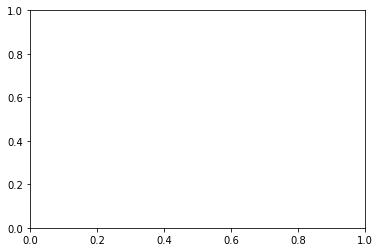

In [55]:
plt.plot(nbars, shifts3a)
#plt.plot(nbars, shifts3b)
#plt.plot(nbars, shifts5a)
#plt.plot(nbars, shifts5b)
plt.plot(nbars, shifts7a)
#plt.plot(nbars, shifts7b)

In [54]:
shifts3a[0]

-0.0035167605871094846